# Import needed modules

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
from timm import create_model
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from tqdm import tqdm

In [12]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get Data

In [13]:
# Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Training', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Testing', transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


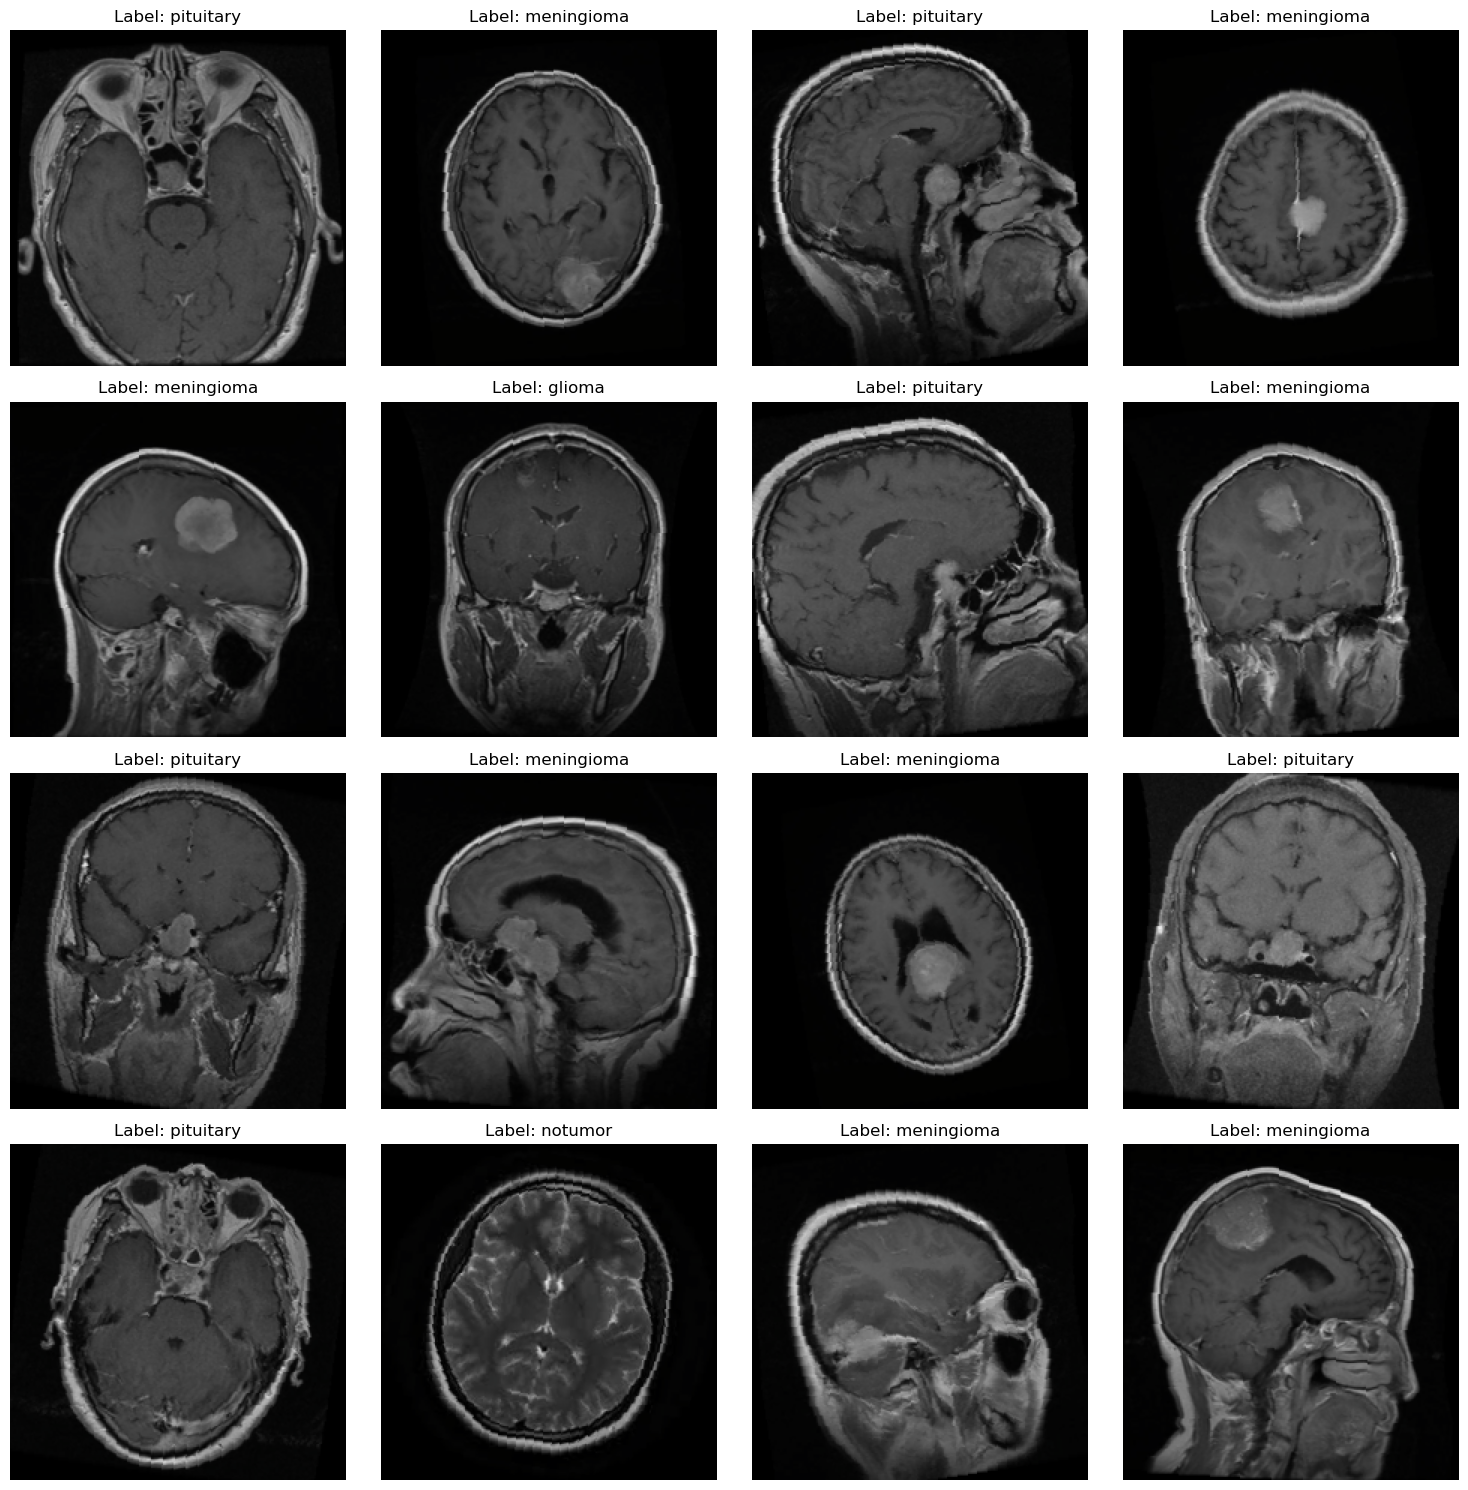

In [14]:
# Load a batch of images and labels for visualization
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model Architecture for ViT-Gru Classifier

In [ ]:
class TemporalAttention(nn.Module):
    def __init__(self, hidden_size):
        super(TemporalAttention, self).__init__()
        self.attn_weights = nn.Linear(hidden_size, 1)

    def forward(self, x):
        attn_scores = self.attn_weights(x).squeeze(-1)  # Shape: (batch_size, seq_len)
        attn_weights = torch.softmax(attn_scores, dim=1)  # Shape: (batch_size, seq_len)
        weighted_output = torch.sum(x * attn_weights.unsqueeze(-1), dim=1)  # Shape: (batch_size, hidden_size)
        return weighted_output

class HybridViTGRUClassifier(nn.Module):
    def __init__(self, num_classes, vit_model_name='vit_base_patch16_224', gru_hidden_size=1024, dropout=0.5):
        super(HybridViTGRUClassifier, self).__init__()

        # Load a pre-trained Vision Transformer model (ViT) without the classifier head
        self.vit = create_model(vit_model_name, pretrained=True, num_classes=0)  # No classification head
        self.vit_head_in_features = self.vit.num_features  # Typically 768 for ViT Base
        self.vit.head = nn.Identity()  # Remove the classifier head
        
        # Fine-tuning ViT: unfreeze transformer layers after some initial layers
        for param in self.vit.parameters():
            param.requires_grad = False  # Freeze all parameters
        for param in self.vit.blocks[6:].parameters():  # Fine-tune the last layers (optional)
            param.requires_grad = True

        # GRU layer for temporal modeling
        self.gru = nn.GRU(input_size=self.vit_head_in_features, 
                          hidden_size=gru_hidden_size, 
                          num_layers=2, 
                          batch_first=True, 
                          dropout=dropout, 
                          bidirectional=True)
        
        # Layer normalization to stabilize training

        self.attention = TemporalAttention(gru_hidden_size * 2)  # Bidirectional GRU output size

        # Fully connected layers for final classification
        self.fc = nn.Sequential(
            nn.Linear(gru_hidden_size * 2, 512),  # GRU is bidirectional, so multiply hidden size by 2
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Ensure input has batch and sequence dimensions
        if len(x.shape) == 4:  # Single image input: (batch_size, channels, height, width)
            x = x.unsqueeze(1)  # Add a dummy sequence dimension: (batch_size, 1, channels, height, width)

        batch_size, seq_len, channels, height, width = x.shape
        
        # Flatten the sequence dimension for batch processing in ViT
        x = x.view(batch_size * seq_len, channels, height, width)  # Shape: (batch_size * seq_len, channels, height, width)
        
        # Extract features from ViT
        vit_features = self.vit(x)  # Shape: (batch_size * seq_len, vit_features)
        
        # Check if vit_features is None
        if vit_features is None:
            raise ValueError("ViT feature extraction failed. Check the input image size or model setup.")

        # Reshape back to sequence format for GRU
        vit_features = vit_features.view(batch_size, seq_len, -1)  # Shape: (batch_size, seq_len, vit_features)

        # Pass the features through the GRU
        gru_out, _ = self.gru(vit_features)  # GRU output shape: (batch_size, seq_len, hidden_size * 2)

        # Apply layer normalization on GRU output
        attended_output = self.attention(gru_out)

        # Pass through fully connected layers for final classification
        output = self.fc(attended_output)
        
        return output


model = HybridViTGRUClassifier(num_classes=4)
# Load a pre-trained ResNet model and modify the classifier
model.to(device)

HybridViTGRUClassifier(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate

# Model Training Loop

In [17]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
# Initialize lists to store training history
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
train_all_preds = []
train_all_labels = []
val_all_preds = []
val_all_labels = []

In [20]:
num_epochs = 50

# Store metrics for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, train_recalls, train_f1_scores = [], [], []
val_precisions, val_recalls, val_f1_scores = [], [], []

# Start your training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')

    # ========================== Training Phase ============================
    model.train()  # Set model to training mode
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for inputs, labels in train_loader:  # train_loader should be defined
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * inputs.size(0)

        # Store predictions and labels for later metric calculations
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculate training loss and append to the list
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Calculate metrics for training
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    train_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    # Store training metrics
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1)

    # ========================== Validation Phase ============================
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_labels = []
    val_preds = []

    with torch.no_grad():  # Disable gradient tracking during evaluation
        for inputs, labels in val_loader:  # val_loader should be defined
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass (no gradient computation)
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Store predictions and labels for later metric calculations
            _, preds = torch.max(outputs, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(preds.cpu().numpy())

    # Calculate validation loss and append to the list
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    # Calculate metrics for validation
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_precision = precision_score(val_labels, val_preds, average='macro', zero_division=0)
    val_recall = recall_score(val_labels, val_preds, average='macro', zero_division=0)
    val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)

    # Store validation metrics
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)

    # Print metrics for this epoch
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/50
Epoch 1/50 - Train Loss: 0.3464, Train Accuracy: 0.8930, Val Loss: 0.4358, Val Accuracy: 0.8604
Epoch 2/50
Epoch 2/50 - Train Loss: 0.4826, Train Accuracy: 0.8333, Val Loss: 0.5903, Val Accuracy: 0.7902
Epoch 3/50
Epoch 3/50 - Train Loss: 0.3765, Train Accuracy: 0.8782, Val Loss: 0.3239, Val Accuracy: 0.8955
Epoch 4/50
Epoch 4/50 - Train Loss: 0.3959, Train Accuracy: 0.8659, Val Loss: 0.3063, Val Accuracy: 0.8955
Epoch 5/50
Epoch 5/50 - Train Loss: 0.3313, Train Accuracy: 0.8932, Val Loss: 0.7624, Val Accuracy: 0.7544
Epoch 6/50
Epoch 6/50 - Train Loss: 0.3176, Train Accuracy: 0.8958, Val Loss: 0.3390, Val Accuracy: 0.8955
Epoch 7/50
Epoch 7/50 - Train Loss: 0.2558, Train Accuracy: 0.9186, Val Loss: 0.3041, Val Accuracy: 0.9252
Epoch 8/50
Epoch 8/50 - Train Loss: 0.3084, Train Accuracy: 0.9016, Val Loss: 0.2825, Val Accuracy: 0.9207
Epoch 9/50
Epoch 9/50 - Train Loss: 0.2404, Train Accuracy: 0.9293, Val Loss: 0.2484, Val Accuracy: 0.9260
Epoch 10/50
Epoch 10/50 - Train Loss:

# Train and Validation from ViT-Gru Hybrid Model Visualized

Length of train_losses: 50
Length of val_losses: 50
Length of train_accuracies: 50
Length of val_accuracies: 50


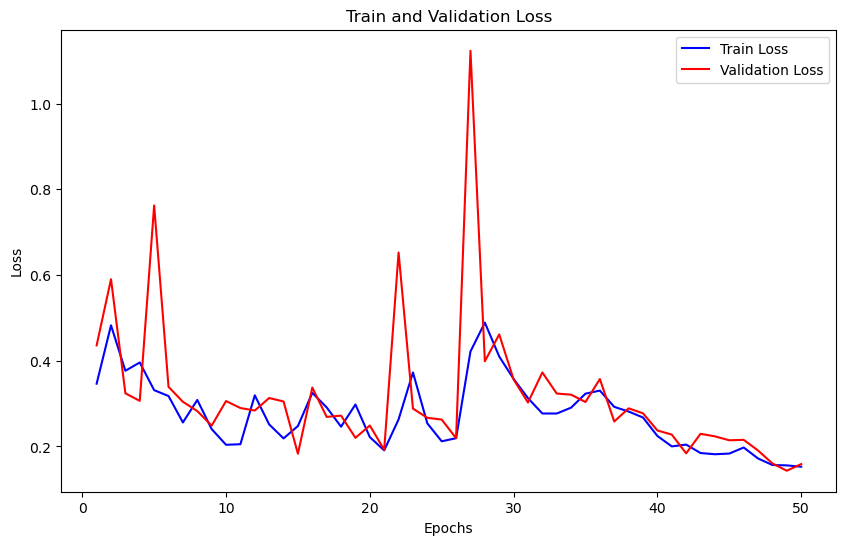

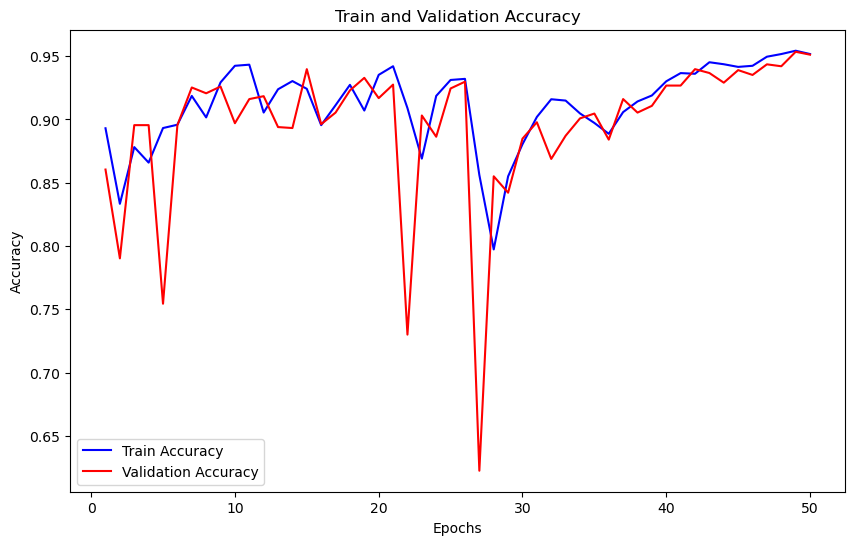

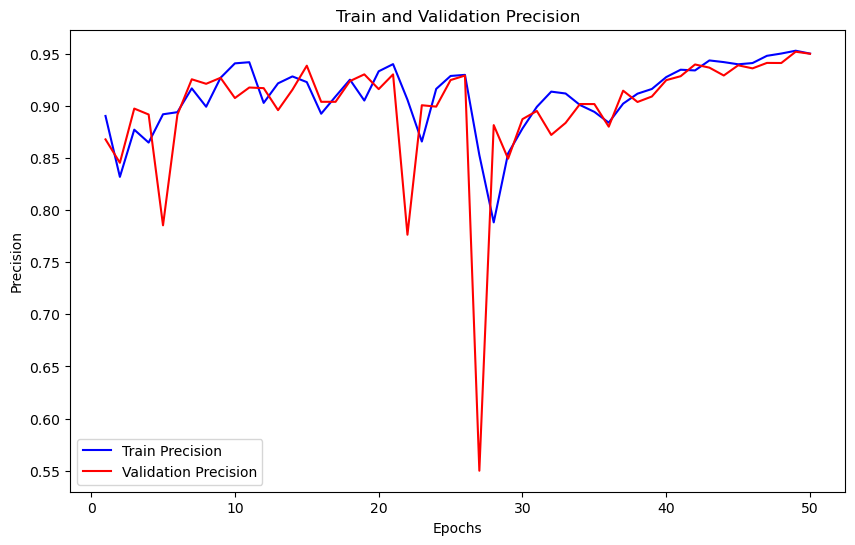

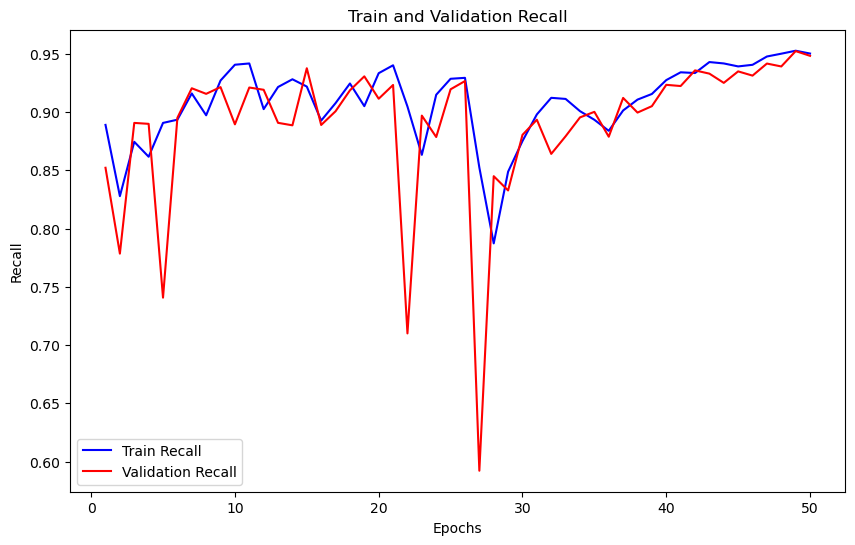

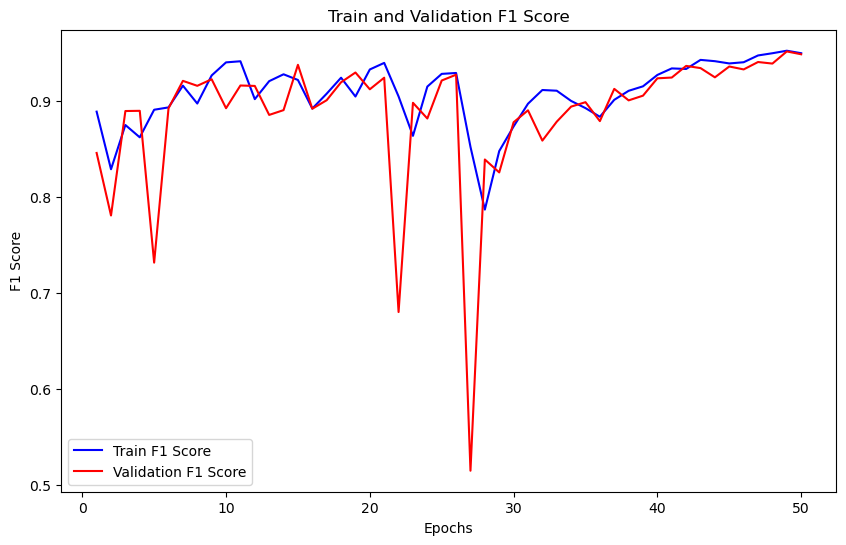

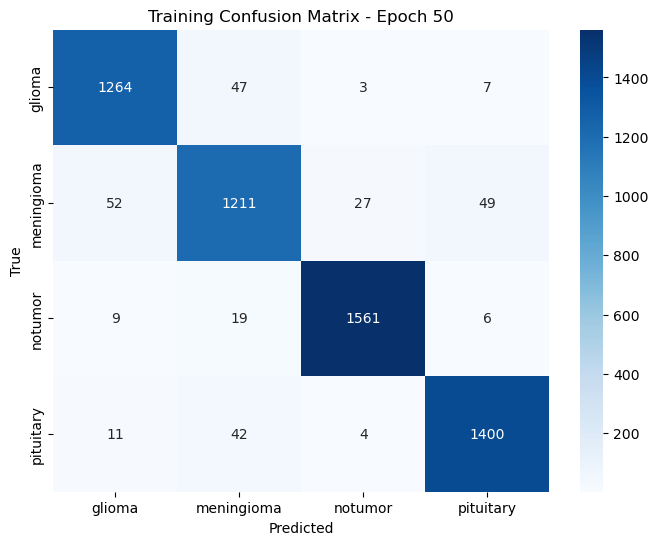

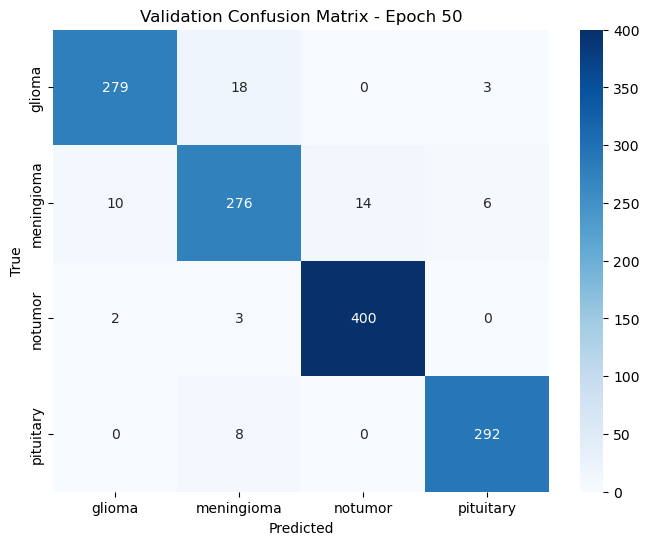

Epoch 50/50 - Train Loss: 0.1525, Train Accuracy: 0.9517, Val Loss: 0.1587, Val Accuracy: 0.9512


In [21]:
# Check the lengths of the lists before assertion
print(f"Length of train_losses: {len(train_losses)}")
print(f"Length of val_losses: {len(val_losses)}")
print(f"Length of train_accuracies: {len(train_accuracies)}")
print(f"Length of val_accuracies: {len(val_accuracies)}")

# Ensure all lists are the same length as num_epochs before plotting
assert len(train_losses) == len(val_losses) == len(train_accuracies) == len(val_accuracies) == num_epochs, \
    f"Lengths mismatch: train_losses({len(train_losses)}), val_losses({len(val_losses)}), train_accuracies({len(train_accuracies)}), val_accuracies({len(val_accuracies)})"

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation precision
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_precisions, label='Train Precision', color='blue')
plt.plot(range(1, num_epochs+1), val_precisions, label='Validation Precision', color='red')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Train and Validation Precision')
plt.legend()
plt.show()

# Plot training and validation recall
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_recalls, label='Train Recall', color='blue')
plt.plot(range(1, num_epochs+1), val_recalls, label='Validation Recall', color='red')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Train and Validation Recall')
plt.legend()
plt.show()

# Plot training and validation F1 score
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_f1_scores, label='Train F1 Score', color='blue')
plt.plot(range(1, num_epochs+1), val_f1_scores, label='Validation F1 Score', color='red')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Train and Validation F1 Score')
plt.legend()
plt.show()

# ========================== Confusion Matrix ============================
# Plot confusion matrix for training phase
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_loader.dataset.classes, yticklabels=train_loader.dataset.classes)
plt.title(f'Training Confusion Matrix - Epoch {epoch+1}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot confusion matrix for validation phase
cm_val = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=val_loader.dataset.classes, yticklabels=val_loader.dataset.classes)
plt.title(f'Validation Confusion Matrix - Epoch {epoch+1}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f"Epoch {epoch+1}/{num_epochs} - "
      f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
      f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Calculate the MSE, RMSE, MAE and R-squared value for additional metrics

In [ ]:
mse = mean_squared_error(val_labels, val_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(val_labels, val_preds)
r2 = r2_score(val_labels, val_preds)

print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


MSE: 0.1037, RMSE: 0.3221, MAE: 0.0656, R²: 0.9109


# Model Architecture for GN-SVM Hybrid Model 

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 378MB/s] 
100%|██████████| 82/82 [01:13<00:00,  1.12it/s]


Train Accuracy: 1.0
Validation Accuracy: 0.9260106788710908
Confusion Matrix:
[[250  45   0   5]
 [  7 278   4  17]
 [  0   3 402   0]
 [  2  13   1 284]]


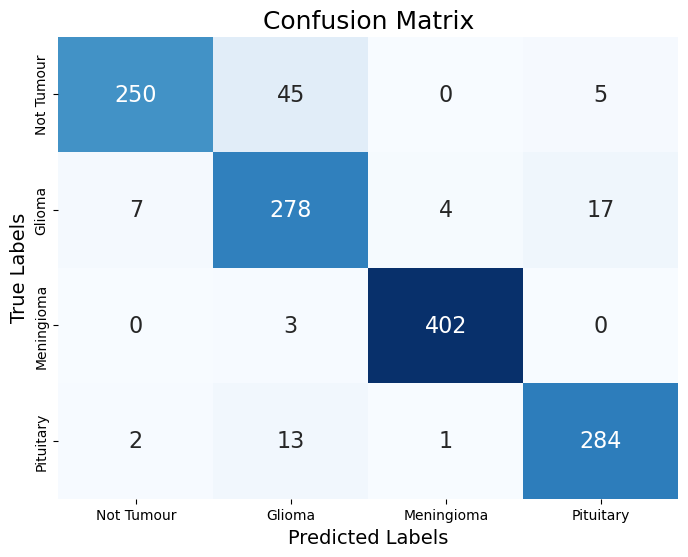

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       300
           1       0.82      0.91      0.86       306
           2       0.99      0.99      0.99       405
           3       0.93      0.95      0.94       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



100%|██████████| 357/357 [05:52<00:00,  1.01it/s]


In [ ]:
class HybridGN_SVM(nn.Module):
    def __init__(self, num_classes, gru_hidden_size=1024, attention_heads=8, dropout=0.5):
        super(HybridGN_SVM, self).__init__()

        # Step 1: Load the Pretrained GoogleNet Model without the classifier head
        self.gn = models.inception_v3(pretrained=True)
        self.gn.fc = nn.Identity()  # Retain the feature extractor

        # The output of InceptionV3 has a feature size of 2048
        self.gn_head_in_features = 2048

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((2, 2))  # Change to a 2x2 pooling size


        for param in self.gn.parameters():
            param.requires_grad = True  # Unfreeze for fine-tuning
        for param in list(self.gn.parameters())[:5]:  # Freeze initial layers
            param.requires_grad = False


        # Step 2: GRU Layer for Temporal Modeling (if you want to include a sequence)
        self.gru = nn.GRU(
            input_size=self.gn_head_in_features, 
            hidden_size=gru_hidden_size, 
            num_layers=5,  # Increase the number of layers
            batch_first=True, 
            dropout=dropout,  # Apply dropout between layers
            bidirectional=True  # Use bidirectional GRU for better context
        )

        for name, param in self.gru.named_parameters():
            if "weight" in name:
                nn.init.orthogonal_(param)
            elif "bias" in name:
                nn.init.constant_(param, 0)


        self.multihead_attention = nn.MultiheadAttention(
            embed_dim=gru_hidden_size * 2,  # Match GRU's bidirectional output
            num_heads=attention_heads,
            dropout=dropout,
            batch_first=True
        )


        # Step 3: Layer normalization for stable training
        self.layer_norm = nn.LayerNorm(gru_hidden_size * 2)  # Bidirectional GRU output

        # Step 4: Fully connected layers for classification
        self.fc = nn.Sequential(
            nn.Linear(gru_hidden_size * 2, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(p=0.4),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(p=0.4),
            nn.Linear(128, num_classes)
        )


    def forward(self, x):
        # Ensure input has batch and sequence dimensions
        if len(x.shape) == 4:  # Single image input: (batch_size, channels, height, width)
            x = x.unsqueeze(1)  # Add a dummy sequence dimension: (batch_size, 1, channels, height, width)

        batch_size, seq_len, channels, height, width = x.shape
        
        # Flatten the sequence dimension for batch processing in GoogleNet (InceptionV3)
        x = x.view(batch_size * seq_len, channels, height, width)  # Shape: (batch_size * seq_len, channels, height, width)
        
        # Step 5: Feature extraction using GoogleNet (InceptionV3)
        vit_features = self.gn(x)  # Shape: (batch_size * seq_len, feature_size)
        
        # Reshape back to sequence format for GRU
        vit_features = vit_features.view(batch_size, seq_len, -1)  # Shape: (batch_size, seq_len, feature_size)

        # Step 6: Pass the features through the GRU
        gru_out, _ = self.gru(vit_features)  # GRU output shape: (batch_size, seq_len, hidden_size * 2)
        gru_out = gru_out + vit_features  # Residual connection

        attention_out, attention_weights = self.multihead_attention(gru_out, gru_out, gru_out)  # Self-attention
        attention_out = attention_out + gru_out  # Residual connection

        # Step 7: Apply layer normalization on GRU output
        gru_out_last = self.layer_norm(gru_out[:, -1, :])  # Get the last sequence element
        # Additional Attention Weight
        attention_weights = self.attention(gru_out).squeeze(-1)  # Shape: (batch_size, seq_len)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), gru_out).squeeze(1)  # Weighted sum

        # Average attention weights across time (optional for visualization)
        avg_attention_weights = attention_weights.mean(dim=1)
        
        # Step 8: Pass through fully connected layers for final classification
        output = self.fc(gru_out_last)
        
        return output, avg_attention_weights

        def init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        
        self.fc.apply(init_weights)


# Step 9: Feature Extraction and SVM Training

def extract_features(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    features = []
    labels = []

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader):
            # Forward pass through the model to extract features
            vit_features = model.gn(inputs)  # Shape: (batch_size, 2048)
            features.append(vit_features)
            labels.append(targets)

    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    return features.numpy(), labels.numpy()

def train_svm(train_loader, val_loader, model):
    # Extract features for training and validation sets
    train_features, train_labels = extract_features(train_loader, model)
    val_features, val_labels = extract_features(val_loader, model)

    # Step 10: Apply PCA for dimensionality reduction (optional)
    pca = PCA(n_components=100)  # Reduce to 100 components (adjust as needed)
    train_features = pca.fit_transform(train_features)
    val_features = pca.transform(val_features)

    # Step 11: Train the SVM classifier
    svm_model = SVC(kernel='poly', degree=3, C=10, gamma=0.1)
    svm_model.fit(train_features, train_labels)

    # Step 12: Evaluate the model
    train_predictions = svm_model.predict(train_features)
    val_predictions = svm_model.predict(val_features)

    # Print Accuracy
    print("Train Accuracy:", accuracy_score(train_labels, train_predictions))
    print("Validation Accuracy:", accuracy_score(val_labels, val_predictions))

    # Step 13: Print and plot the Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(val_labels, val_predictions))

    # Class names for visualization
    class_names = ['Not Tumour', 'Glioma', 'Meningioma', 'Pituitary']
    plot_confusion_matrix(val_labels, val_predictions, class_names)

    # Print Classification Report
    print("Classification Report:")
    print(classification_report(val_labels, val_predictions))

    return val_labels, val_predictions, class_names

def plot_confusion_matrix(y_true, y_pred, class_names, cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred)
    
    # Plotting the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                xticklabels=class_names, yticklabels=class_names, 
                cbar=False, annot_kws={"size": 16})
    
    plt.title('Confusion Matrix', fontsize=18)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.show()

# Instantiate the model
num_classes = 4  # For classification: Not Tumour, Glioma, Meningioma, Pituitary
model = HybridGN_SVM(num_classes=num_classes)

# Train the SVM and retrieve the validation labels and predictions
val_labels, val_predictions, class_names = train_svm(train_loader, val_loader, model)

# Extract features for visualization
features, labels = extract_features(train_loader, model)

# Apply TSNE for visualization
from sklearn.manifold import TSNE
features_2d = TSNE(n_components=2).fit_transform(features)


# Create a feature visualization with t-SNE for different types of brain tumour

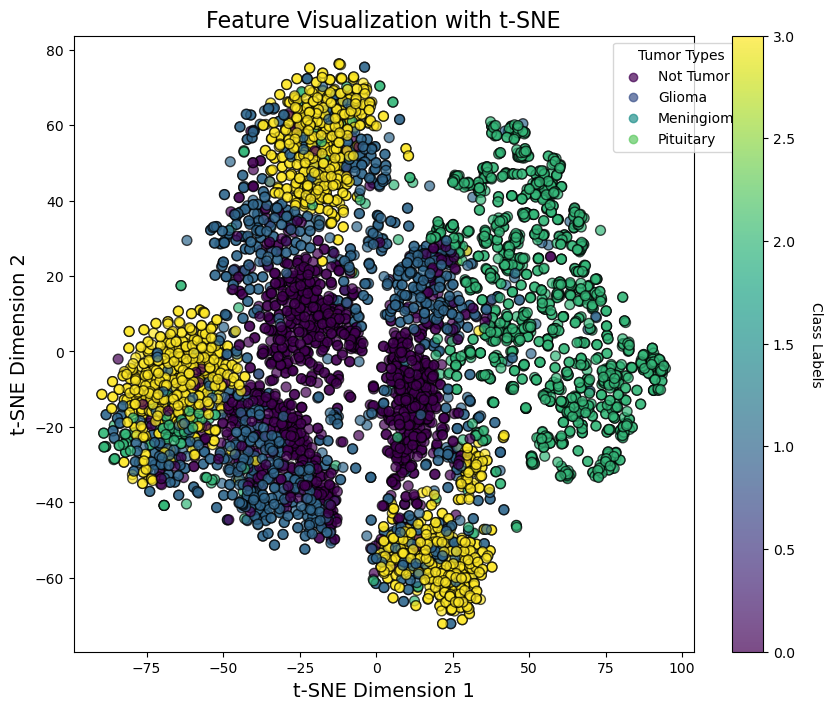

In [24]:
# Create the plot with enhanced visualization
plt.figure(figsize=(10, 8))

# Set color map
cmap = plt.cm.viridis

# Scatter plot with color mapping to class labels
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap=cmap, alpha=0.7, edgecolors='k', s=50)

# Add a colorbar with class labels
cbar = plt.colorbar(scatter)
cbar.set_label('Class Labels', rotation=270, labelpad=20)

# Add title and labels
plt.title('Feature Visualization with t-SNE', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)

# Create a custom legend with class labels
# Define your specific tumor classes
class_labels = np.unique(labels)
class_names = ['Not Tumor', 'Glioma', 'Meningioma', 'Pituitary']  # Modify class names accordingly

# Adding a scatter plot for each class to create the legend
for i, class_label in enumerate(class_labels):
    plt.scatter([], [], c=[cmap(i / len(class_labels))], label=class_names[i], alpha=0.7)

# Add legend
plt.legend(title="Tumor Types", loc="upper right", bbox_to_anchor=(1.1, 1))

# Show the plot
plt.show()

# Bar chart for classification report

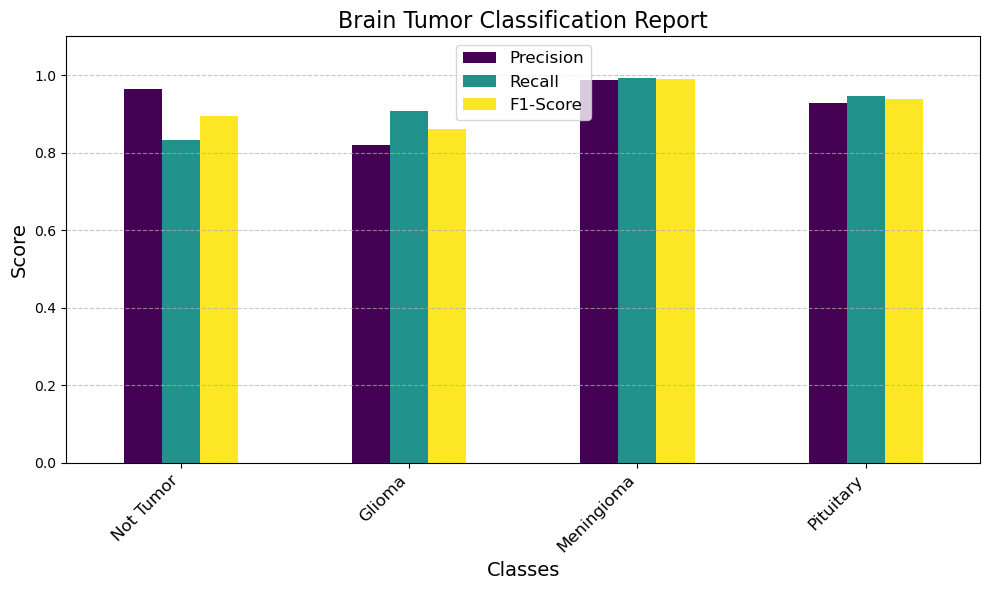

In [ ]:
def plot_classification_report(y_true, y_pred, class_names, cmap="viridis"):
    # Generate the classification report as a dictionary
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    # Convert the dictionary to a DataFrame for easier plotting
    report_df = pd.DataFrame(report_dict).transpose()

    # Exclude "accuracy", "macro avg", and "weighted avg" for class-wise metrics
    class_metrics = report_df.iloc[:-3, :3]  # Select precision, recall, and f1-score for each class

    # Plot bar chart
    class_metrics.plot(kind='bar', figsize=(10, 6), colormap=cmap)

    # Add labels and title
    plt.title("Brain Tumor Classification Report", fontsize=16)
    plt.ylabel("Score", fontsize=14)
    plt.xlabel("Classes", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.ylim(0, 1.1)  # Limit y-axis to show scores between 0 and 1
    plt.legend(["Precision", "Recall", "F1-Score"], fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_classification_report(val_labels, val_predictions, class_names)


# Saving Model

In [26]:
torch.save(model.state_dict(), 'best_model.pth')
print('Model Saved Sucssfully !')

Model Saved Sucssfully !
